<a href="https://colab.research.google.com/github/aliaghababaee/SLO_Asieh/blob/main/VGG_%2B_Optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)

In [3]:
import tensorflow as tf
from keras.layers import Input
import numpy as np
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
!unzip /content/drive/MyDrive/train_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/train_thickness_retina_iran.zip
 extracting: train_labels.pkl        
 extracting: train_thickness_retina.pkl  
 extracting: train_sp.pkl            


In [5]:
!unzip /content/drive/MyDrive/test_thickness_retina_iran.zip

Archive:  /content/drive/MyDrive/test_thickness_retina_iran.zip
 extracting: test_labels.pkl         
 extracting: test_thickness_retina.pkl  
 extracting: test_sp.pkl             


In [6]:
!unzip /content/drive/MyDrive/train_SLO_iran.zip

Archive:  /content/drive/MyDrive/train_SLO_iran.zip
 extracting: train_slo_iran.pkl      
 extracting: train_labels_Iran.pkl   
 extracting: train_sp_iran.pkl       


In [7]:
!unzip /content/drive/MyDrive/test_SLO_iran.zip

Archive:  /content/drive/MyDrive/test_SLO_iran.zip
 extracting: test_slo_iran.pkl       
 extracting: test_labels_Iran.pkl    
 extracting: test_sp_iran.pkl        


# Typical Run

In [8]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)

In [9]:
import tensorflow as tf
from keras.layers import Input
import numpy as np
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import ConfusionMatrixDisplay

In [10]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_1 (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)


    datagen = ImageDataGenerator(
    rotation_range= 5, # rotation
    zoom_range = 0.1,
    fill_mode='nearest',
    data_format='channels_last',
      )


    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    return batch, batch_label

In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_2 (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)

    datagen = ImageDataGenerator(
        rotation_range= 10, # rotation
        width_shift_range= [-30, 30], # horizontal shift
        #height_shift_range= [-5, 5] , # vertical shift
        zoom_range= 0.2,
        vertical_flip= True , # vertical flip
        #brightness_range= [0.2, 1.5],
          )

    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    ###################################################################
    # Final data
    ###################################################################

    x = np.concatenate([x_train,batch])

    labels = np.concatenate([labels_train,batch_label])

    ############################

    ############################
    return x, labels

In [12]:
from skimage.transform import resize

In [13]:
import numpy as np
def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):

            data.append(np.array(x[i][j] * 255 ))
            label.append(y[i])

            #img = resize (x[i][j], (224, 224, 1), mode = 'constant', preserve_range= True)
            #data.append(img)
            #label.append(y[i])

    data = np.reshape(data, np.shape(data))
    return data, np.array(label)

In [14]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
from sklearn import metrics
import sklearn

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

def metrics_calculation(y_valid, y_pred, y_prob):

    #####################################################
    #Get the confusion matrix
    #####################################################
    ROC_AUC = roc_auc_score(y_valid, y_prob)
    f1 = metrics.f1_score(y_valid, y_pred, average='weighted')
    precision, recall, thresholds = precision_recall_curve(y_valid, y_prob)
    P_R_AUC = auc(recall, precision)
    cm = sklearn.metrics.confusion_matrix(y_valid, y_pred, normalize='pred')
    #Now the normalize the diagonal entries
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_acc = cm.diagonal()

    Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    Sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    Precision   = cm[1,1]/(cm[0,1]+cm[1,1])


    return Specificity, Sensitivity, Precision, f1, ROC_AUC, P_R_AUC, class_acc, cm

In [15]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

def curve_ploting(ax, axx, mean_fpr, aucs, tprs, y_test, y_pred, classifier, kernel=[]):

    ###################### Continuing Ploting ROC curve for each fold and the mean ############

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )

    if kernel:
        ax.set_title(f"ROC Curve of {classifier} classifier ({kernel} kernel) ")
    else:
        ax.set_title(f"ROC Curve of {classifier} classifier")
    ax.legend(loc="lower right")

    ###################### Continuing Ploting P_R_curve for each fold and the mean ############
    ###

    no_skill = len(np.array(y_test)[np.array(y_test)==1]) / len(np.array(y_test))

    axx.plot([0, 1], [no_skill, no_skill], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    axx.plot(
        recall,
        precision,
        color="b",
        label=r"Mean P_R curve (AUC =  %0.2f)" % (auc(recall, precision)),
        lw=2,
        alpha=0.8,
    )


    # axis labels
    axx.set_xlabel('Recall')
    axx.set_ylabel('Precision')
    # show the legend
    axx.legend(loc="lower left")
    if kernel:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier ({kernel} kernel)')
    else:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier')

In [16]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import numpy as np

def fold_curves(ax, axx, y_valid, fold_number, mean_fpr, pred_proba, tprs=[], aucs=[]):
    ############ ROC Curve
    lr_fpr, lr_tpr, _ = roc_curve(y_valid, pred_proba)
    roc_auc = roc_auc_score(y_valid, pred_proba)
    ax.plot(lr_fpr, lr_tpr, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, roc_auc))
    # axis labels
    ax.set_xlabel('False Positive Rate (Positive label: 1.0)')
    ax.set_ylabel('True Positive Rate (Positive label: 1.0)')

    interp_tpr = np.interp(mean_fpr, lr_fpr, lr_tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)


    ############ P_R Curve
    precision, recall, _ = precision_recall_curve(y_valid, pred_proba)
    # plot the model precision-recall curve
    axx.plot(recall, precision, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, auc(recall, precision)))

    return tprs, aucs

In [17]:
number_class=2
cnn_accc_5iteration=[]
cnn_spp_5iteration=[]
cnn_see_5iteration=[]
cnn_prr_5iteration=[]
cnn_f11_5iteration=[]
cnn_aucc_5iteration=[]
cnn_pr_aucc_5iteration=[]
class_acc_5iteration = np.zeros((5,number_class))


test_accc_5iteration=[]
test_spp_5iteration=[]
test_see_5iteration=[]
test_prr_5iteration=[]
test_f11_5iteration=[]
test_aucc_5iteration=[]
test_pr_aucc_5iteration=[]
class_acc_test_5iteration = np.zeros((5,number_class))
n_iter=0

In [18]:
x_train.shape

NameError: name 'x_train' is not defined

vgg16

In [22]:
#feature extractor for vgg16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3),
        )


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())
    model.add(Dense(1185, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1160, activation='relu'))
    model.add(Dropout(0.0))
    model.add(Dense(622, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(3692, activation='relu'))
    model.add(Dropout(0.7))
    ##################################
    #################################  EFFECT OF Hidden NEURONS  ###################
    model.add(Dense(3544, activation='relu'))
    model.add(Dense((n_class-1), activation='sigmoid'))
    return model


resnet101 with 255

In [ ]:
#feature extractor for vgg16

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())

    model.add (Dense (482, activation = 'relu'))
    model.add(Dropout(0.1))
    model.add (Dense (4019, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(332, activation='relu'))
    model.add(Dropout(0.6))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dropout(0.7))
    ##################################
    #################################  EFFECT OF Hidden NEURONS  ###################
    #model.add(Dense(3544, activation='relu'))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


Resnet101 without 255

In [ ]:
#Resnet101 without 255


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())


    model.add (Dense (2335, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


resnet 50

In [ ]:
#Resnet101 without 255


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(60, 256, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())


    model.add (Dense (102, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


custom CNN

In [24]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout, Input

def cnn_feature_extractor(n_filters=16, n_class=2):


  model = Sequential()
  input_img = Input((60, 256, 1))

  model.add(Conv2D(n_filters * 1, kernel_size=3, activation='relu',input_shape= input_img.shape[1:], padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 2, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 4, kernel_size=3, activation='relu',padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 8, kernel_size=3, activation='relu',padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())



  model.add(Flatten())

  #model.add (Dropout (0.3))

  model.add(Dense(730, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(25, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(19, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(9, activation='relu'))
  #model.add(Dropout(0.1))

  model.add(Dense((n_class-1), activation='sigmoid'))

  return model

In [ ]:
plt.imshow (x_train [270,:,:,0], cmap = 'jet')

In [23]:
model.summary ()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 60, 256, 16)       160       
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 30, 128, 16)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_36 (Ba  (None, 30, 128, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_38 (Conv2D)          (None, 30, 128, 32)       4640      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 15, 64, 32)        0         
 ng2D)                                                           
                                                     

In [ ]:
images_test.shape

(38, 60, 256, 1)

In [ ]:
model = cnn_feature_extractor ()

---------------------------------------------------------------------          
 			 1th fold 
---------------------------------------------------------------------




Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 60, 256, 16)       160       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 30, 128, 16)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_40 (Ba  (None, 30, 128, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_42 (Conv2D)          (None, 30, 128, 32)       4640      
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 15, 64, 32)        0         
 ng2D)                                                           
                                                     

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 60, 256, 16)       160       
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 30, 128, 16)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_44 (Ba  (None, 30, 128, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_46 (Conv2D)          (None, 30, 128, 32)       4640      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 15, 64, 32)        0         
 ng2D)                                                           
                                                     

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_49 (Conv2D)          (None, 60, 256, 16)       160       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 30, 128, 16)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_48 (Ba  (None, 30, 128, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_50 (Conv2D)          (None, 30, 128, 32)       4640      
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 15, 64, 32)        0         
 ng2D)                                                           
                                                     

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 60, 256, 16)       160       
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 30, 128, 16)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_52 (Ba  (None, 30, 128, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_54 (Conv2D)          (None, 30, 128, 32)       4640      
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 15, 64, 32)        0         
 ng2D)                                                           
                                                     

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 60, 256, 16)       160       
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 30, 128, 16)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_56 (Ba  (None, 30, 128, 16)       64        
 tchNormalization)                                               
                                                                 
 conv2d_58 (Conv2D)          (None, 30, 128, 32)       4640      
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 15, 64, 32)        0         
 ng2D)                                                           
                                                     

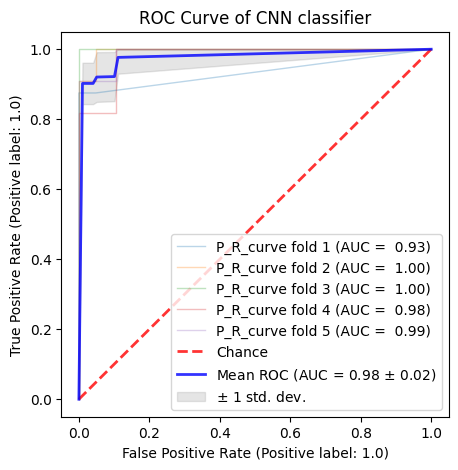

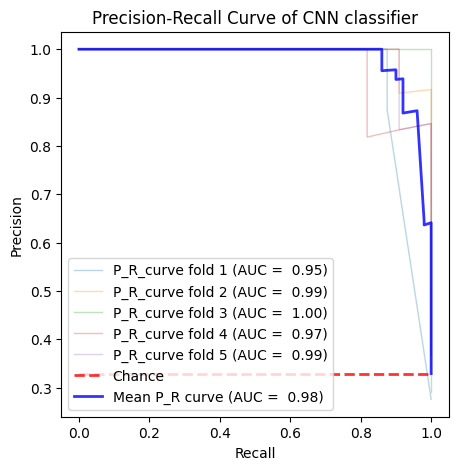

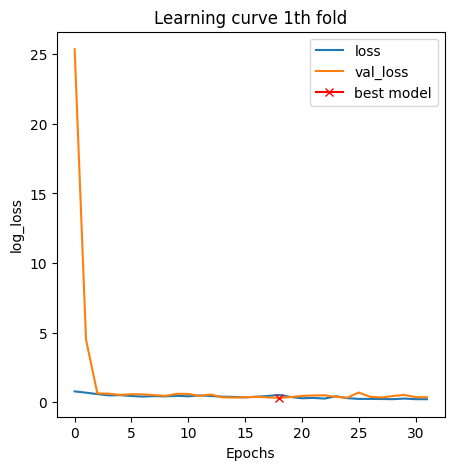

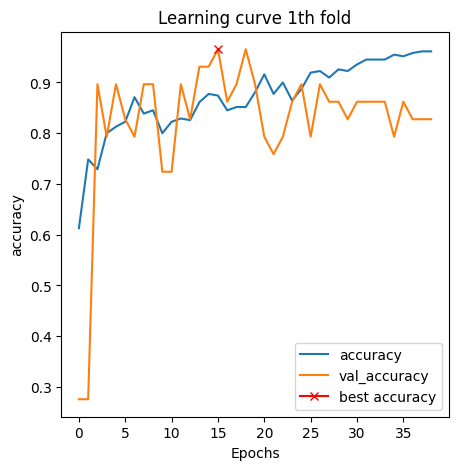

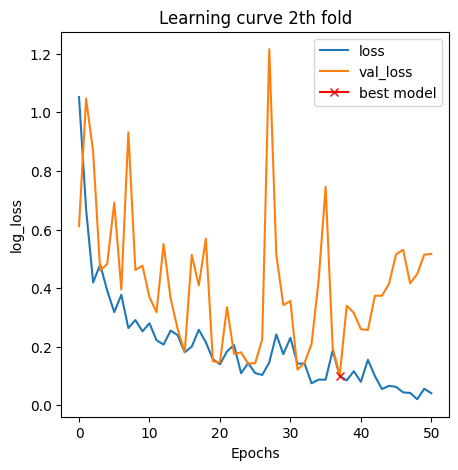

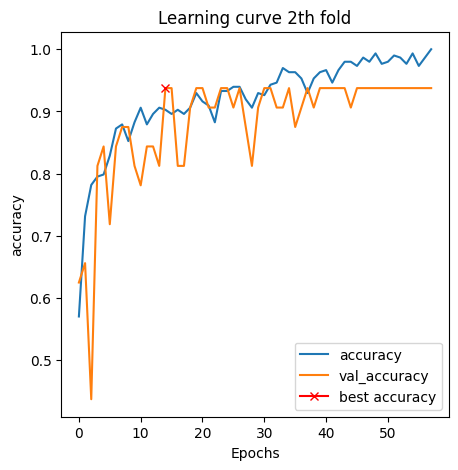

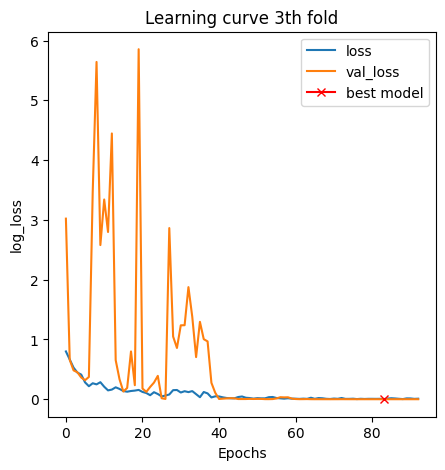

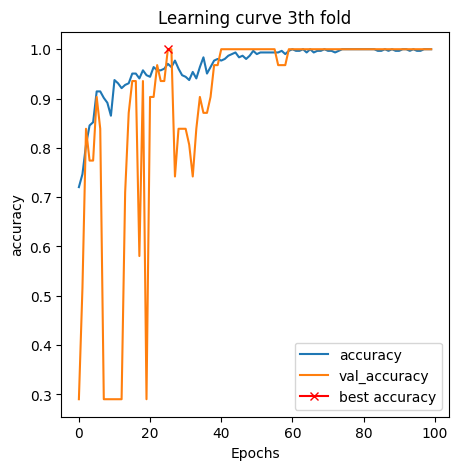

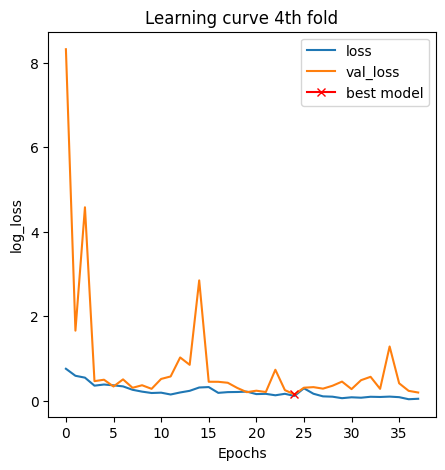

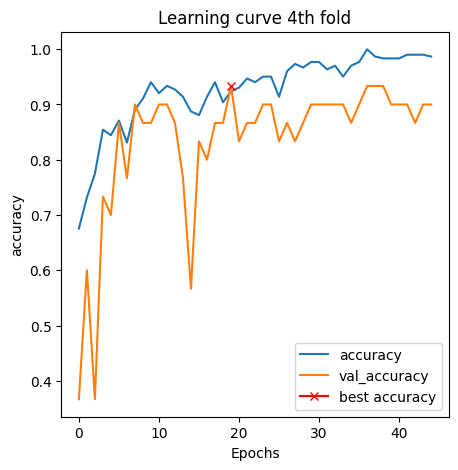

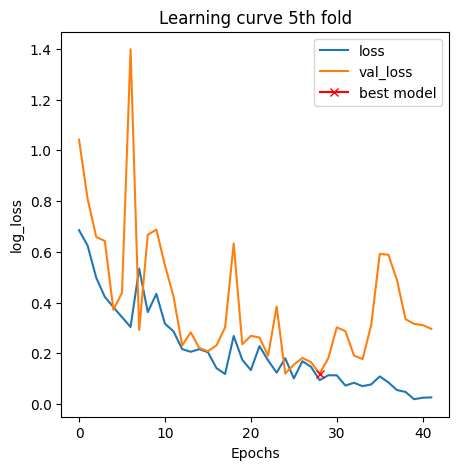

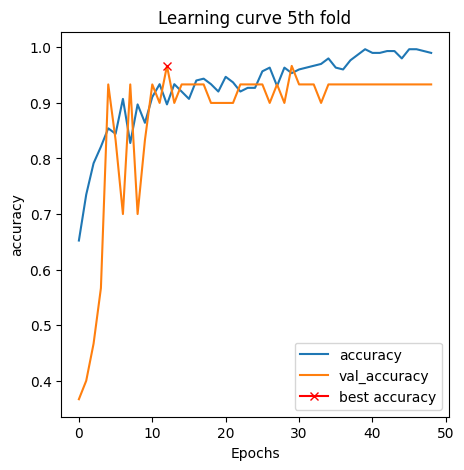

cnn_acc     = 0.940603
cnn_sp      = 0.923333
cnn_se      = 0.958804
cnn_pr      = 0.928884
cnn_f1      = 0.940607
cnn_auc     = 0.980297
cnn_pr_auc  = 0.978806

acc of class Normal = 0.923333
acc of class MS = 0.958804

test_acc     = 0.815789
test_sp      = 0.762519
test_se      = 0.867801
test_pr      = 0.783591
test_f1      = 0.815809
test_auc     = 0.883036
test_pr_auc  = 0.806587

test acc of class Normal = 0.762519
test acc of class MS = 0.867801



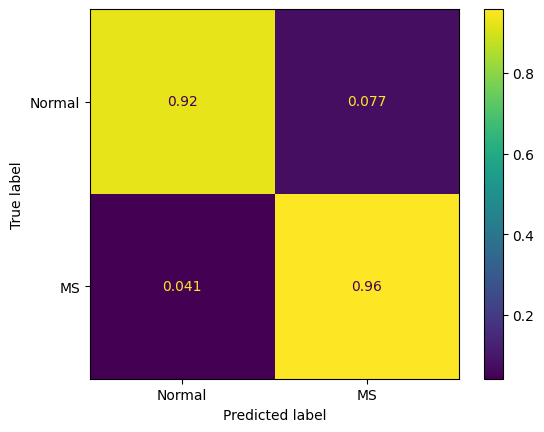

In [25]:
images_train = pickle.load(open("/content/" + "train_thickness_retina.pkl", 'rb'))
labels_train = pickle.load(open("/content/" +"train_labels.pkl", 'rb'))

images_test = pickle.load(open("/content/drive/MyDrive/" +"test_thickness_new.pkl", 'rb'))
labels_test = pickle.load(open("/content/" +"test_labels.pkl", 'rb'))
images_test,labels_test = preparing(images_test,labels_test)

#images_test = np.repeat (images_test, repeats = 3, axis = 3)
#####################################################################
## Parameters
#####################################################################
channel = 1
number_class = 2

cnn_acc    = []
cnn_se     = []
cnn_sp     = []
cnn_pr     = []
cnn_f1     = []
cnn_auc    = []
cnn_pr_auc = []

test_acc    = []
test_se     = []
test_sp     = []
test_pr     = []
test_f1     = []
test_auc    = []
test_pr_auc = []


class_acc = np.zeros((number_class))
class_acc_test = np.zeros((number_class))

target_names = ['Normal' , 'MS']
confusion_matrix = np.zeros((number_class, number_class))
confusion_matrix_test = np.zeros((number_class, number_class))

y_test = []
tprs   = []
aucs   = []
y_pred = []
x_test = {}

mean_fpr  = np.linspace(0, 1, 100)
fig, ax   = plt.subplots(figsize=(5, 5))
fig1, ax1 = plt.subplots(figsize=(5, 5))


#### model parameters for vgg
batch_size_vgg    = 8
epoch         = 100
filter_num    = 32
learning_rate_vgg =  0.0004036650839061106




#### model parameters for res101 with 255
batch_size_res255    = 64
epoch         = 100
filter_num    = 32
learning_rate_res255 =  0.0003720165816110892


#### model parameters for res101 without 255
batch_size_res    = 32
epoch         = 100
filter_num    = 32
learning_rate_res =  0.008509082186113752


#### model parameters for res50 with 255
batch_size_res50    = 16
epoch         = 100
filter_num    = 32
learning_rate_res50 =  0.002658420292718515


#### model parameters for cnn
batch_size_cnn    = 8
epoch         = 100
filter_num    = 32
learning_rate_cnn =  0.0001982405748511496

#####################################################################
## Applying kfold
#####################################################################

nfold = 5  #please enter number of folds

kf_nfold = StratifiedKFold(n_splits=nfold, random_state=None, shuffle=True)

n = 0
for train_index, val_index in kf_nfold.split(images_train,list(labels_train.values())):
    n = n+1
    # print(train_index, val_index)  # you can watch train and validation index using this comment
    print(f'---------------------------------------------------------------------\
          \n \t\t\t {n}th fold \n---------------------------------------------------------------------'\
          ,end = '\n\n\n' )
    train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

    x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

    x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

    y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

    y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

    x_train,y_train = preparing(x_train,y_train)

    x_valid,y_valid = preparing(x_valid,y_valid)

    #x_test[n] = x_valid
    ################# Augmentation

    indices = np.where(y_train == 1)[0]

    x_train_ms = x_train[indices]
    y_train_ms = y_train[indices]

    x_train_ms_aug,y_train_ms_aug = Augmentation_1(x_train_ms,y_train_ms)

    x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
    y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

    indices = np.random.permutation (len (x_train))

    x_train_shuf = x_train [indices]
    y_train_shuf = y_train [indices]

    x_train,y_train = Augmentation_2(x_train_shuf,y_train_shuf)

    indices = np.random.permutation (len (x_train))

    x_train = x_train [indices]
    y_train = y_train [indices]

    #x_train = np.repeat (x_train, repeats = 3, axis = 3)

    #x_valid = np.repeat (x_valid, repeats = 3, axis = 3)

    ####################################################################
    # classification
    ####################################################################

    input_img = Input((np.shape(x_train)[1], np.shape(x_train)[2], channel))

    model = cnn_feature_extractor()


    METRICS = [
#      keras.metrics.TruePositives(name='tp'),
#      keras.metrics.FalsePositives(name='fp'),
#      keras.metrics.TrueNegatives(name='tn'),
#      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
#      keras.metrics.Precision(name='precision'),
#      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
#      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      ]


    my_optimizer =  tf.keras.optimizers.Adam(lr=learning_rate_cnn)
    model.compile(optimizer=my_optimizer, loss="binary_crossentropy", metrics=METRICS)
    callbacks = [EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
        ModelCheckpoint(f'oct{n}.h5', verbose=1, save_best_only=True, save_weights_only=True)]

    model.summary()

    #################################
    ###### Applying model  ###########
    #################################
    results = model.fit(x_train, y_train, batch_size=batch_size_cnn, epochs=epoch, callbacks=callbacks,\
                    validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)))


    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["loss"][:-7], label="loss")
    plt.plot(results.history["val_loss"][:-7], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["accuracy"], label="accuracy")
    plt.plot(results.history["val_accuracy"], label="val_accuracy")
    plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]),\
             marker="x", color="r", label="best accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()


    # load the best model
    model.load_weights(f'oct{n}.h5')


    pred_proba = model.predict(x_valid).ravel()
    pred_class = (pred_proba > 0.5).astype(np.uint8)


    ##### calculating metrics

    cnn_acc.append(metrics.accuracy_score(y_valid, pred_class))
    print(f'accuracy of {n}th fold : {metrics.accuracy_score(y_valid, pred_class)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(y_valid, pred_class, pred_proba)

    cnn_sp.append(SP)
    cnn_se.append(SE)
    cnn_pr.append(PR)
    cnn_f1.append(f1)
    cnn_auc.append(ROC_AUC)
    cnn_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc  = np.add(class_acc,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix = np.add(confusion_matrix,cm)

######################## internal test
    pred_proba_test = model.predict(images_test).ravel()
    pred_class_test = (pred_proba_test > 0.5).astype(np.uint8)


    ##### calculating metrics
    print(f'test accuracy of {n}th fold : {metrics.accuracy_score(labels_test, pred_class_test)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(labels_test, pred_class_test, pred_proba_test)

    test_acc.append(metrics.accuracy_score(labels_test, pred_class_test))
    test_sp.append(SP)
    test_se.append(SE)
    test_pr.append(PR)
    test_f1.append(f1)
    test_auc.append(ROC_AUC)
    test_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc_test  = np.add(class_acc_test,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix_test = np.add(confusion_matrix_test,cm)

    ###################### Ploting ROC and PR curves for each fold ############
    y_test = np.append(y_test, y_valid, axis = 0)
    y_pred = np.append(y_pred, pred_proba, axis = 0)
    ###
    tprs, aucs = fold_curves(ax, ax1, y_valid, n, mean_fpr, pred_proba, tprs, aucs)

######################  the mean Ploting ROC and PR curves ############
###
curve_ploting(ax, ax1, mean_fpr, aucs, tprs, y_test, y_pred, 'CNN' )

plt.show()

#######################################
    # ploting confusion matrix
#######################################
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix/nfold, display_labels=target_names)
disp.plot()


########################################
#     Metrics printing
########################################
cnn_accc     = np.mean(cnn_acc)
cnn_spp      = np.mean(cnn_sp)
cnn_see      = np.mean(cnn_se)
cnn_prr      = np.mean(cnn_pr)
cnn_f11      = np.mean(cnn_f1)
cnn_aucc     = np.mean(cnn_auc)
cnn_pr_aucc  = np.mean(cnn_pr_auc)

###################### internal test
test_accc     = np.mean(test_acc)
test_spp      = np.mean(test_sp)
test_see      = np.mean(test_se)
test_prr      = np.mean(test_pr)
test_f11      = np.mean(test_f1)
test_aucc     = np.mean(test_auc)
test_pr_aucc  = np.mean(test_pr_auc)

#################### acc for each class ##################
class_acc  = class_acc/nfold
class_acc_test  = class_acc_test/nfold

print('cnn_acc     = %f' % cnn_accc)
print('cnn_sp      = %f' % cnn_spp)
print('cnn_se      = %f' % cnn_see)
print('cnn_pr      = %f' % cnn_prr)
print('cnn_f1      = %f' % cnn_f11)
print('cnn_auc     = %f' % cnn_aucc)
print('cnn_pr_auc  = %f' % cnn_pr_aucc, end='\n\n')


print('acc of class %s' % target_names[0], '= %f' % class_acc[0])
print('acc of class %s' % target_names[1], '= %f' % class_acc[1], end='\n\n')

print('test_acc     = %f' % test_accc)
print('test_sp      = %f' % test_spp)
print('test_se      = %f' % test_see)
print('test_pr      = %f' % test_prr)
print('test_f1      = %f' % test_f11)
print('test_auc     = %f' % test_aucc)
print('test_pr_auc  = %f' % test_pr_aucc, end='\n\n')


print('test acc of class %s' % target_names[0], '= %f' % class_acc_test[0])
print('test acc of class %s' % target_names[1], '= %f' % class_acc_test[1], end='\n\n')

In [ ]:
x_train.shape

(302, 60, 256, 3)

In [ ]:
test_acc

[0.9736842105263158,
 0.9473684210526315,
 0.9210526315789473,
 0.8421052631578947,
 0.9210526315789473]

In [ ]:
cnn_acc

[1.0, 0.96875, 0.9354838709677419, 1.0, 0.9666666666666667]

# Optuna State of the arts

In [ ]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.trial import TrialState
from optuna.integration import TFKerasPruningCallback

In [ ]:
####################### state of the arts ##############################

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
import tensorflow as tf
from keras.layers import Input

def classifier (trial):

  # Load the pre-trained VGG16 model without the top (fully connected) layers
  base_model = tf.keras.applications.resnet.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(60,256, 3),
        )



  # Freeze the pre-trained layers so they are not trainable during training
  #for layer in base_model.layers:
    #layer.trainable = False

  base_model.trainable = False

  model = Sequential ()

  model.add (base_model)

  model.add (Flatten ())

  dropout_l0 = trial.suggest_float("dropout_l0", 0, 0.7,step=0.1)

  model.add (Dropout (dropout_l0))


  n_layers = trial.suggest_int("n_layers", 1, 5)


  for i in range(n_layers):


      n_units = trial.suggest_int("n_units_l{}".format(i), 16, 4096, log = True)

      model.add (Dense (n_units, activation = 'relu'))

      dropout = trial.suggest_float("dropout_l{}".format (i+1), 0, 0.7,step=0.1)

      model.add (Dropout (rate = dropout))

  model.add (Dense (1, activation = 'sigmoid'))

  lr = trial.suggest_float ('lr', 1e-5, 1e-1, log = True)

  my_optimizer = tf.keras.optimizers.Adam (learning_rate= lr)


  model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics='accuracy')


  return model

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = 42)
import keras
import pickle
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):
            data.append(np.array(x[i][j] * 255))
            label.append(y[i])
            #img = resize (x[i][j], (224, 224, 1), mode = 'constant', preserve_range= True)
            #data.append (img)
            #label.append (y [i])


    data = np.reshape(data , np.shape(data))
    return data, np.array(label)




def objective (trial):

  keras.backend.clear_session()

  datagen = ImageDataGenerator(
  rotation_range= 5, # rotation
  zoom_range = 0.1,
  fill_mode='nearest',
  data_format='channels_last',
    )

  datagen2 = ImageDataGenerator(
  #rotation_range= 5, # rotation
  width_shift_range= [-30, 30], # horizontal shift
  #height_shift_range= [-5, 5] , # vertical shift
  zoom_range= 0.2,
  vertical_flip= True , # vertical flip
  #brightness_range= [0.2, 1.5]
    )


  images_train = pickle.load(open("/content/"+"train_thickness_retina.pkl", 'rb'))
  labels_train = pickle.load(open("/content/"+"train_labels.pkl", 'rb'))

  train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

  x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

  x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

  y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

  y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

  x_train,y_train = preparing(x_train,y_train)

  x_valid,y_valid = preparing(x_valid,y_valid)


  #rotation_angle  = trial.suggest_float("rotation_angle", 0, 40, step = 10)
  #zoom_range = trial.suggest_float("zoom_range", 0, 0.5, step = 0.1)

  #color_jitter_brightness = trial.suggest_float ("color_jitter_brightness", 0.1, 0.8, step = 0.1)
  #shift_horizontal = trial.suggest_uniform("shift_horizontal", 0, 0.7)
  #shift_vertical = trial.suggest_uniform("shift_vertical", 0, 0.7)
  #vertical_flip_prob = trial.suggest_float ("vertical_flip_prob", 0, 1, step = 0.1)

  indices = np.where(y_train == 1)[0]

  x_train_ms = x_train[indices]
  y_train_ms = y_train[indices]
  #################Augmentation##################################

  # First Augmentation

  x_train_ms_aug =np.zeros_like(x_train_ms, dtype=np.float32)

  y_train_ms_aug =np.zeros_like(y_train_ms, dtype=np.float32)

  for i in range(len(x_train_ms)):

    x1= x_train_ms[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_ms_aug [i,:,:,:] = x.next()

    y_train_ms_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
  y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

  indices = np.random.permutation (len (x_train))

  x_train_shuf = x_train [indices]
  y_train_shuf = y_train [indices]

  # Second Augmentation

  x_train_aug =np.zeros_like(x_train_shuf, dtype=np.float32)

  y_train_aug =np.zeros_like(y_train_shuf, dtype=np.float32)

  for i in range(len(x_train_aug)):

    x1= x_train_aug[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen2.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_aug [i,:,:,:] = x.next()

    y_train_aug [i] = y_train[i]

    x_train = np.concatenate ((x_train_shuf, x_train_aug), axis=0)
    y_train = np.concatenate ((y_train_shuf, y_train_aug), axis = 0)


  ###############################################################################33


  x_train = np.repeat (x_train, repeats = 3, axis = 3)

  x_valid = np.repeat (x_valid, repeats = 3, axis = 3)
        ####################################################################
        # classification via my model
        ####################################################################
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

  model = classifier (trial)


  # Generate our trial model.


  model.fit(x_train,
            np.asarray(y_train, dtype=np.float64),
            batch_size= batch_size,
            epochs=50,
            callbacks=[TFKerasPruningCallback(trial, "val_accuracy"), EarlyStopping(patience=20, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
            ModelCheckpoint(f'slo.h5', verbose=1, save_best_only=True, save_weights_only=True)],
            validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)),
            )
  model.load_weights(f'slo.h5')
  score = model.evaluate (x_valid, np.asarray(y_valid, dtype=np.float64), verbose = 1)

  return score [1]


In [ ]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=100)

[I 2024-02-27 13:10:26,572] A new study created in memory with name: no-name-d217da3a-913a-40df-98fe-a327efb9a426


94765736/94765736 [==============================] - 3s 0us/step
Epoch 1/50
37/38 [============================>.] - ETA: 0s - loss: 215.9333 - accuracy: 0.5743
Epoch 1: val_loss improved from inf to 21.11790, saving model to slo.h5
38/38 [==============================] - 7s 77ms/step - loss: 210.3427 - accuracy: 0.5789 - val_loss: 21.1179 - val_accuracy: 0.9032 - lr: 0.0150
Epoch 2/50
37/38 [============================>.] - ETA: 0s - loss: 16.9565 - accuracy: 0.6520
Epoch 2: val_loss improved from 21.11790 to 13.00579, saving model to slo.h5
38/38 [==============================] - 2s 41ms/step - loss: 16.7470 - accuracy: 0.6480 - val_loss: 13.0058 - val_accuracy: 0.8710 - lr: 0.0150
Epoch 3/50
37/38 [============================>.] - ETA: 0s - loss: 5.5060 - accuracy: 0.6926
Epoch 3: val_loss improved from 13.00579 to 0.22013, saving model to slo.h5
38/38 [==============================] - 2s 52ms/step - loss: 5.3718 - accuracy: 0.6875 - val_loss: 0.2201 - val_accuracy: 0.9032 - lr

[I 2024-02-27 13:11:00,961] Trial 0 finished with value: 0.8709677457809448 and parameters: {'batch_size': 8, 'dropout_l0': 0.5, 'n_layers': 2, 'n_units_l0': 2193, 'dropout_l1': 0.4, 'n_units_l1': 320, 'dropout_l2': 0.30000000000000004, 'lr': 0.015046730121581885}. Best is trial 0 with value: 0.8709677457809448.


Epoch 1/50
18/19 [===========================>..] - ETA: 0s - loss: 4.2443 - accuracy: 0.5625
Epoch 1: val_loss improved from inf to 0.24456, saving model to slo.h5
19/19 [==============================] - 6s 114ms/step - loss: 4.0793 - accuracy: 0.5592 - val_loss: 0.2446 - val_accuracy: 0.8065 - lr: 0.0040
Epoch 2/50
17/19 [=========================>....] - ETA: 0s - loss: 0.6820 - accuracy: 0.5515
Epoch 2: val_loss did not improve from 0.24456
19/19 [==============================] - 0s 13ms/step - loss: 0.7352 - accuracy: 0.5493 - val_loss: 0.2473 - val_accuracy: 0.9355 - lr: 0.0040
Epoch 3/50
17/19 [=========================>....] - ETA: 0s - loss: 0.6388 - accuracy: 0.5404
Epoch 3: val_loss did not improve from 0.24456
19/19 [==============================] - 0s 13ms/step - loss: 0.6407 - accuracy: 0.5428 - val_loss: 0.2675 - val_accuracy: 0.8387 - lr: 0.0040
Epoch 4/50
17/19 [=========================>....] - ETA: 0s - loss: 0.5776 - accuracy: 0.6250
Epoch 4: val_loss improved fr

[I 2024-02-27 13:11:21,756] Trial 1 finished with value: 0.9354838728904724 and parameters: {'batch_size': 16, 'dropout_l0': 0.7, 'n_layers': 1, 'n_units_l0': 30, 'dropout_l1': 0.7, 'lr': 0.003977746565261027}. Best is trial 1 with value: 0.9354838728904724.


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.8999 - accuracy: 0.5888
Epoch 1: val_loss improved from inf to 0.46240, saving model to slo.h5
5/5 [==============================] - 9s 515ms/step - loss: 0.8999 - accuracy: 0.5888 - val_loss: 0.4624 - val_accuracy: 0.7097 - lr: 7.2342e-05
Epoch 2/50
3/5 [=================>............] - ETA: 0s - loss: 0.7444 - accuracy: 0.5990
Epoch 2: val_loss improved from 0.46240 to 0.45181, saving model to slo.h5
5/5 [==============================] - 1s 126ms/step - loss: 0.7713 - accuracy: 0.5987 - val_loss: 0.4518 - val_accuracy: 0.7097 - lr: 7.2342e-05
Epoch 3/50
3/5 [=================>............] - ETA: 0s - loss: 0.8022 - accuracy: 0.5156
Epoch 3: val_loss did not improve from 0.45181
5/5 [==============================] - 0s 36ms/step - loss: 0.7359 - accuracy: 0.5691 - val_loss: 0.4557 - val_accuracy: 0.7097 - lr: 7.2342e-05
Epoch 4/50
3/5 [=================>............] - ETA: 0s - loss: 0.6848 - accuracy: 0.5781

[W 2024-02-27 13:11:35,966] Trial 2 failed with parameters: {'batch_size': 64, 'dropout_l0': 0.1, 'n_layers': 4, 'n_units_l0': 40, 'dropout_l1': 0.0, 'n_units_l1': 35, 'dropout_l2': 0.7, 'n_units_l2': 20, 'dropout_l3': 0.1, 'n_units_l3': 20, 'dropout_l4': 0.2, 'lr': 7.234221982319829e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-36-9f7e61481ded>", line 148, in objective
    model.fit(x_train,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handl

KeyboardInterrupt: 

In [ ]:
figure = plt.figure (figsize = (96, 96))
for i in range (len (x_train)):
  figure.add_subplot (20, 20, i+1)
  plt.imshow (x_train [i] [:,:,0], cmap = 'jet')
  plt.axis ('off')
plt.savefig ('augmented2.jpg')
plt.show ()

In [ ]:
x_train

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  22
  Number of pruned trials:  13
  Number of complete trials:  8
Best trial:
  Value:  1.0
  Params: 
    batch_size: 16
    n_layers: 1
    n_units_l0: 102
    dropout_l0: 0.2
    lr: 0.002658420292718515


In [ ]:
!unzip /content/drive/MyDrive/train_thickness_retina_iran.zip

In [ ]:
!unzip /content/drive/MyDrive/test_thickness_retina_iran.zip

# Optuna Custom CNN

In [25]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.trial import TrialState
from optuna.integration import TFKerasPruningCallback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
import tensorflow as tf
from keras.layers import Input

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
from keras.layers import Input

def classifier (trial):
  model = Sequential()
  input_img = Input((60, 256, 1))
  n_filters = trial.suggest_categorical("n_filters", [8, 16, 20, 25, 32, 64])
  print(f'n_filters = {n_filters}')

  model.add(Conv2D(n_filters * 1, kernel_size=3, activation='relu',input_shape=input_img.shape[1:], padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 2, kernel_size=3, activation='relu', padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 4, kernel_size=3, activation='relu',padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())


  model.add(Conv2D(n_filters * 8, kernel_size=3, activation='relu',padding='same'))
  model.add(MaxPool2D(2, 2))
  model.add(BatchNormalization())



  model.add (Flatten ())

  dropout_l0 = trial.suggest_float("dropout_l0", 0, 0.7,step=0.1)

  model.add (Dropout (dropout_l0))


  n_layers = trial.suggest_int("n_layers", 1, 5)


  for i in range(n_layers):

      n_units = trial.suggest_int("n_units_l{}".format(i), 8, 2048, log = True)

      model.add (Dense (n_units, activation = 'relu'))

      dropout = trial.suggest_float("dropout_l{}".format (i+1), 0, 0.7,step=0.1)

      model.add (Dropout (rate = dropout))

  model.add (Dense (1, activation = 'sigmoid'))

  lr = trial.suggest_float ('lr', 1e-5, 1e-3, log = True)

  my_optimizer = tf.keras.optimizers.Adam (learning_rate= lr)


  model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics='accuracy')


  return model

In [28]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = 42)
import keras
import pickle
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):
            data.append(np.array(x[i][j] * 255))
            label.append(y[i])


    data = np.reshape(data, np.shape(data))
    return data, np.array(label)




def objective (trial):

  keras.backend.clear_session()

  datagen = ImageDataGenerator(
  rotation_range= 5, # rotation
  zoom_range = 0.1,
  fill_mode='nearest',
  data_format='channels_last',
    )

  datagen2 = ImageDataGenerator(
  rotation_range= 10, # rotation
  width_shift_range= [-30, 30], # horizontal shift
  #height_shift_range= [-5, 5] , # vertical shift
  zoom_range= 0.2,
  vertical_flip= True , # vertical flip
  #brightness_range= [0.2, 1.5]
    )


  images_train = pickle.load(open("/content/"+"train_thickness_retina.pkl", 'rb'))
  labels_train = pickle.load(open("/content/"+"train_labels.pkl", 'rb'))

  train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

  x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

  x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

  y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

  y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

  x_train,y_train = preparing(x_train,y_train)

  x_valid,y_valid = preparing(x_valid,y_valid)


  #rotation_angle  = trial.suggest_float("rotation_angle", 0, 40, step = 10)
  #zoom_range = trial.suggest_float("zoom_range", 0, 0.5, step = 0.1)

  #color_jitter_brightness = trial.suggest_float ("color_jitter_brightness", 0.1, 0.8, step = 0.1)
  #shift_horizontal = trial.suggest_uniform("shift_horizontal", 0, 0.7)
  #shift_vertical = trial.suggest_uniform("shift_vertical", 0, 0.7)
  #vertical_flip_prob = trial.suggest_float ("vertical_flip_prob", 0, 1, step = 0.1)

  indices = np.where(y_train == 1)[0]

  x_train_ms = x_train[indices]
  y_train_ms = y_train[indices]
  #################Augmentation##################################

  # First Augmentation

  x_train_ms_aug =np.zeros_like(x_train_ms, dtype=np.float32)

  y_train_ms_aug =np.zeros_like(y_train_ms, dtype=np.float32)

  for i in range(len(x_train_ms)):

    x1= x_train_ms[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_ms_aug [i,:,:,:] = x.next()

    y_train_ms_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train, x_train_ms_aug), axis=0)
  y_train = np.concatenate ((y_train, y_train_ms_aug), axis = 0)

  indices = np.random.permutation (len (x_train))

  x_train_shuf = x_train [indices]
  y_train_shuf = y_train [indices]

  # Second Augmentation

  x_train_aug =np.zeros_like(x_train_shuf, dtype=np.float32)

  y_train_aug =np.zeros_like(y_train_shuf, dtype=np.float32)

  for i in range(len(x_train_aug)):

    x1= x_train_aug[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen2.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_aug [i,:,:,:] = x.next()

    y_train_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train_shuf, x_train_aug), axis=0)
  y_train = np.concatenate ((y_train_shuf, y_train_aug), axis = 0)

  indices = np.random.permutation (len (x_train))

  x_train_shuf = x_train [indices]
  y_train_shuf = y_train [indices]




  ###############################################################################33


  # x_train = np.repeat (x_train, repeats = 3, axis = 3)

  # x_valid = np.repeat (x_valid, repeats = 3, axis = 3)
        ####################################################################
        # classification via my model
        ####################################################################
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

  model = classifier (trial)


  # Generate our trial model.


  model.fit(x_train,
            np.asarray(y_train, dtype=np.float64),
            batch_size= batch_size,
            epochs=50,
            callbacks=[TFKerasPruningCallback(trial, "val_accuracy"), EarlyStopping(patience=10, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
            ModelCheckpoint(f'oct.h5', verbose=1, save_best_only=True, save_weights_only=True)],
            validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)),
            )
  model.load_weights(f'oct.h5')
  score = model.evaluate (x_valid, np.asarray(y_valid, dtype=np.float64), verbose = 1)

  return score [1]


In [ ]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=100)

In [30]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  89
  Number of complete trials:  11
Best trial:
  Value:  1.0
  Params: 
    batch_size: 8
    n_filters: 16
    dropout_l0: 0.0
    n_layers: 4
    n_units_l0: 73
    dropout_l1: 0.1
    n_units_l1: 25
    dropout_l2: 0.0
    n_units_l2: 19
    dropout_l3: 0.30000000000000004
    n_units_l3: 9
    dropout_l4: 0.0
    lr: 0.0001982405748511496


# Optuna for SLO

In [8]:
!pip install optuna
!pip install optuna-integration
import optuna
from optuna.trial import TrialState
from optuna.integration import TFKerasPruningCallback

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.0 MB/s eta 0:00:00


In [9]:
####################### state of the arts ##############################

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout
import tensorflow as tf
from keras.layers import Input

def classifier (trial):

  # Load the pre-trained VGG16 model without the top (fully connected) layers
  base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3),
        )



  # Freeze the pre-trained layers so they are not trainable during training
  #for layer in base_model.layers:
    #layer.trainable = False

  base_model.trainable = False

  model = Sequential ()

  model.add (base_model)

  model.add (Flatten ())

  dropout_l0 = trial.suggest_float("dropout_l0", 0, 0.7,step=0.1)

  model.add (Dropout (dropout_l0))


  n_layers = trial.suggest_int("n_layers", 1, 5)


  for i in range(n_layers):


      n_units = trial.suggest_int("n_units_l{}".format(i), 16, 4096, log = True)

      model.add (Dense (n_units, activation = 'relu'))

      dropout = trial.suggest_float("dropout_l{}".format (i+1), 0, 0.7,step=0.1)

      model.add (Dropout (rate = dropout))

  model.add (Dense (1, activation = 'sigmoid'))

  lr = trial.suggest_float ('lr', 1e-5, 1e-1, log = True)

  my_optimizer = tf.keras.optimizers.Adam (learning_rate= lr)


  model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics='accuracy')


  return model

In [ ]:
slo = pickle.load (open ('/content/train_slo_iran.pkl', 'rb'))

In [ ]:
labels = pickle.load (open ('/content/train_labels_Iran.pkl', 'rb'))

In [ ]:
images, labels = preparing (slo, labels)

In [ ]:
images.shape

(209, 128, 128, 1)

In [10]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)
import keras
import pickle
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):
            img = resize (x[i][j], (128, 128, 1), mode = 'constant', preserve_range= True)
            data.append (img)
            label.append (y [i])


    data = np.reshape(data , np.shape(data))
    return data, np.array(label)




def objective (trial):

  keras.backend.clear_session()

  datagen2 = ImageDataGenerator(
  rotation_range= 5, # rotation
  width_shift_range= [-30, 30], # horizontal shift
  height_shift_range= [-5, 5] , # vertical shift
  zoom_range= 0.2,
  vertical_flip= True , # vertical flip
  brightness_range= [0.2, 1.5]
    )


  images_train = pickle.load(open("/content/"+"train_slo_iran.pkl", 'rb'))
  labels_train = pickle.load(open("/content/"+"train_labels_Iran.pkl", 'rb'))

  train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

  x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

  x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

  y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

  y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

  x_train,y_train = preparing(x_train,y_train)

  x_valid,y_valid = preparing(x_valid,y_valid)


  #rotation_angle  = trial.suggest_float("rotation_angle", 0, 40, step = 10)
  #zoom_range = trial.suggest_float("zoom_range", 0, 0.5, step = 0.1)

  #color_jitter_brightness = trial.suggest_float ("color_jitter_brightness", 0.1, 0.8, step = 0.1)
  #shift_horizontal = trial.suggest_uniform("shift_horizontal", 0, 0.7)
  #shift_vertical = trial.suggest_uniform("shift_vertical", 0, 0.7)
  #vertical_flip_prob = trial.suggest_float ("vertical_flip_prob", 0, 1, step = 0.1)
  #################Augmentation##################################



  x_train_aug =np.zeros_like(x_train, dtype=np.float32)

  y_train_aug =np.zeros_like(y_train, dtype=np.float32)

  for i in range(len(x_train_aug)):

    x1= x_train_aug[i,:,:,:].copy()

    x1=x1.reshape((1, ) + x1.shape)

    x = datagen2.flow(x1, batch_size=1, seed=42) # to make the result reproducible

    x_train_aug [i,:,:,:] = x.next()

    y_train_aug [i] = y_train[i]

  x_train = np.concatenate ((x_train, x_train_aug), axis=0)
  y_train = np.concatenate ((y_train, y_train_aug), axis = 0)


  indices = np.random.permutation (len (x_train))

  x_train = x_train [indices]
  y_train = y_train [indices]


  ###############################################################################33


  x_train = np.repeat (x_train, repeats = 3, axis = 3)

  x_valid = np.repeat (x_valid, repeats = 3, axis = 3)

        ####################################################################
        # classification via my model
        ####################################################################
  batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64, 128])

  model = classifier (trial)


  # Generate our trial model.


  model.fit(x_train,
            np.asarray(y_train, dtype=np.float64),
            batch_size= batch_size,
            epochs=50,
            callbacks=[TFKerasPruningCallback(trial, "val_accuracy"), EarlyStopping(patience=10, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
            ModelCheckpoint(f'slo.h5', verbose=1, save_best_only=True, save_weights_only=True)],
            validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)),
            )
  model.load_weights(f'slo.h5')
  score = model.evaluate (x_valid, np.asarray(y_valid, dtype=np.float64), verbose = 1)

  return score [1]


In [11]:
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())

study.optimize(objective, n_trials=100)

[I 2024-02-27 17:42:26,573] A new study created in memory with name: no-name-167a04eb-b56e-404c-baaa-a6d8f04ed659


171446536/171446536 [==============================] - 5s 0us/step
Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 0.9507 - accuracy: 0.4611
Epoch 1: val_loss improved from inf to 0.60615, saving model to slo.h5
6/6 [==============================] - 16s 787ms/step - loss: 0.9507 - accuracy: 0.4611 - val_loss: 0.6061 - val_accuracy: 0.6667 - lr: 6.2993e-04
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 0.8840 - accuracy: 0.5094
Epoch 2: val_loss improved from 0.60615 to 0.60187, saving model to slo.h5
6/6 [==============================] - 1s 210ms/step - loss: 0.8815 - accuracy: 0.5000 - val_loss: 0.6019 - val_accuracy: 0.6667 - lr: 6.2993e-04
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 0.7885 - accuracy: 0.5094
Epoch 3: val_loss improved from 0.60187 to 0.59059, saving model to slo.h5
6/6 [==============================] - 1s 201ms/step - loss: 0.7846 - accuracy: 0.5150 - val_loss: 0.5906 - val_accuracy: 0.7143 - lr: 6.2993e-

[I 2024-02-27 17:43:19,240] Trial 0 finished with value: 0.8571428656578064 and parameters: {'batch_size': 64, 'dropout_l0': 0.0, 'n_layers': 5, 'n_units_l0': 58, 'dropout_l1': 0.4, 'n_units_l1': 1201, 'dropout_l2': 0.7, 'n_units_l2': 836, 'dropout_l3': 0.6000000000000001, 'n_units_l3': 324, 'dropout_l4': 0.6000000000000001, 'n_units_l4': 504, 'dropout_l5': 0.0, 'lr': 0.0006299309939705562}. Best is trial 0 with value: 0.8571428656578064.


Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 131681.5469 - accuracy: 0.5565
Epoch 1: val_loss improved from inf to 8681.07129, saving model to slo.h5
21/21 [==============================] - 13s 244ms/step - loss: 131681.5469 - accuracy: 0.5565 - val_loss: 8681.0713 - val_accuracy: 0.7805 - lr: 0.0587
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 38923.4883 - accuracy: 0.5536
Epoch 2: val_loss improved from 8681.07129 to 1323.05652, saving model to slo.h5
21/21 [==============================] - 2s 111ms/step - loss: 38923.4883 - accuracy: 0.5536 - val_loss: 1323.0565 - val_accuracy: 0.6829 - lr: 0.0587
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 15666.6904 - accuracy: 0.5476
Epoch 3: val_loss did not improve from 1323.05652
21/21 [==============================] - 1s 32ms/step - loss: 15666.6904 - accuracy: 0.5476 - val_loss: 40255.1445 - val_accuracy: 0.7805 - lr: 0.0587
Epoch 4/50
21/21 [===========================

[I 2024-02-27 17:43:57,495] Trial 1 finished with value: 0.6097561120986938 and parameters: {'batch_size': 16, 'dropout_l0': 0.6000000000000001, 'n_layers': 4, 'n_units_l0': 3079, 'dropout_l1': 0.5, 'n_units_l1': 1864, 'dropout_l2': 0.5, 'n_units_l2': 1360, 'dropout_l3': 0.7, 'n_units_l3': 143, 'dropout_l4': 0.5, 'lr': 0.05873242498879912}. Best is trial 0 with value: 0.8571428656578064.


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 2201.2236 - accuracy: 0.5533
Epoch 1: val_loss improved from inf to 104.55058, saving model to slo.h5
11/11 [==============================] - 11s 441ms/step - loss: 2201.2236 - accuracy: 0.5533 - val_loss: 104.5506 - val_accuracy: 0.9000 - lr: 0.0386
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 653.4146 - accuracy: 0.5680
Epoch 2: val_loss did not improve from 104.55058
11/11 [==============================] - 0s 36ms/step - loss: 653.4146 - accuracy: 0.5680 - val_loss: 399.6707 - val_accuracy: 0.8000 - lr: 0.0386
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 347.4421 - accuracy: 0.6272
Epoch 3: val_loss did not improve from 104.55058
11/11 [==============================] - 0s 37ms/step - loss: 347.4421 - accuracy: 0.6272 - val_loss: 319.6444 - val_accuracy: 0.8500 - lr: 0.0386
Epoch 4/50
11/11 [==============================] - ETA: 0s - loss: 490.4887 - accuracy: 0.6479


[I 2024-02-27 17:44:23,280] Trial 2 finished with value: 0.8999999761581421 and parameters: {'batch_size': 32, 'dropout_l0': 0.0, 'n_layers': 2, 'n_units_l0': 1146, 'dropout_l1': 0.7, 'n_units_l1': 538, 'dropout_l2': 0.4, 'lr': 0.03856909217145789}. Best is trial 2 with value: 0.8999999761581421.


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 145.4428 - accuracy: 0.5089
Epoch 1: val_loss improved from inf to 0.69522, saving model to slo.h5
11/11 [==============================] - 10s 328ms/step - loss: 145.4428 - accuracy: 0.5089 - val_loss: 0.6952 - val_accuracy: 0.5000 - lr: 0.0233
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.4734
Epoch 2: val_loss improved from 0.69522 to 0.69328, saving model to slo.h5
11/11 [==============================] - 2s 157ms/step - loss: 0.6922 - accuracy: 0.4734 - val_loss: 0.6933 - val_accuracy: 0.5000 - lr: 0.0233
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.0695 - accuracy: 0.4527
Epoch 3: val_loss improved from 0.69328 to 0.69319, saving model to slo.h5
11/11 [==============================] - 1s 118ms/step - loss: 1.0695 - accuracy: 0.4527 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 0.0233
Epoch 4/50
11/11 [==============================] - ETA: 0s 

[I 2024-02-27 17:44:53,763] Trial 3 finished with value: 0.5 and parameters: {'batch_size': 32, 'dropout_l0': 0.30000000000000004, 'n_layers': 3, 'n_units_l0': 321, 'dropout_l1': 0.4, 'n_units_l1': 37, 'dropout_l2': 0.2, 'n_units_l2': 2837, 'dropout_l3': 0.2, 'lr': 0.02328926586976931}. Best is trial 2 with value: 0.8999999761581421.


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.9537 - accuracy: 0.5325
Epoch 1: val_loss improved from inf to 0.52014, saving model to slo.h5
22/22 [==============================] - 11s 192ms/step - loss: 0.9537 - accuracy: 0.5325 - val_loss: 0.5201 - val_accuracy: 0.8000 - lr: 2.2336e-05
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.5221 - accuracy: 0.6864
Epoch 2: val_loss improved from 0.52014 to 0.45299, saving model to slo.h5
22/22 [==============================] - 1s 66ms/step - loss: 0.5221 - accuracy: 0.6864 - val_loss: 0.4530 - val_accuracy: 0.8750 - lr: 2.2336e-05
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.7041
Epoch 3: val_loss improved from 0.45299 to 0.26280, saving model to slo.h5
22/22 [==============================] - 2s 73ms/step - loss: 0.4459 - accuracy: 0.7041 - val_loss: 0.2628 - val_accuracy: 0.9500 - lr: 2.2336e-05
Epoch 4/50
22/22 [==============================] - ET

[I 2024-02-27 17:45:28,325] Trial 4 finished with value: 0.949999988079071 and parameters: {'batch_size': 16, 'dropout_l0': 0.4, 'n_layers': 1, 'n_units_l0': 817, 'dropout_l1': 0.1, 'lr': 2.233558783419345e-05}. Best is trial 4 with value: 0.949999988079071.


Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.9814 - accuracy: 0.5947
Epoch 1: val_loss improved from inf to 1.70771, saving model to slo.h5
43/43 [==============================] - 10s 89ms/step - loss: 1.9814 - accuracy: 0.5947 - val_loss: 1.7077 - val_accuracy: 0.8500 - lr: 0.0016
Epoch 2/50
42/43 [============================>.] - ETA: 0s - loss: 0.9515 - accuracy: 0.6875
Epoch 2: val_loss improved from 1.70771 to 1.49423, saving model to slo.h5
43/43 [==============================] - 2s 39ms/step - loss: 0.9479 - accuracy: 0.6893 - val_loss: 1.4942 - val_accuracy: 0.8750 - lr: 0.0016
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.7219
Epoch 3: val_loss improved from 1.49423 to 1.17318, saving model to slo.h5
43/43 [==============================] - 1s 35ms/step - loss: 0.6439 - accuracy: 0.7219 - val_loss: 1.1732 - val_accuracy: 0.9000 - lr: 0.0016
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss:

[I 2024-02-27 17:46:07,826] Trial 5 finished with value: 0.9750000238418579 and parameters: {'batch_size': 8, 'dropout_l0': 0.5, 'n_layers': 1, 'n_units_l0': 22, 'dropout_l1': 0.0, 'lr': 0.0016292158358323944}. Best is trial 5 with value: 0.9750000238418579.


Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 11.7218 - accuracy: 0.5089

[I 2024-02-27 17:46:28,225] Trial 6 pruned. Trial was pruned at epoch 0.


Epoch 1/50
21/22 [===========================>..] - ETA: 0s - loss: 0.7877 - accuracy: 0.5744
Epoch 1: val_loss improved from inf to 0.39858, saving model to slo.h5
22/22 [==============================] - 13s 195ms/step - loss: 0.7832 - accuracy: 0.5769 - val_loss: 0.3986 - val_accuracy: 0.8250 - lr: 7.1882e-05
Epoch 2/50
21/22 [===========================>..] - ETA: 0s - loss: 0.5870 - accuracy: 0.6548
Epoch 2: val_loss improved from 0.39858 to 0.33432, saving model to slo.h5
22/22 [==============================] - 2s 92ms/step - loss: 0.5912 - accuracy: 0.6509 - val_loss: 0.3343 - val_accuracy: 0.7750 - lr: 7.1882e-05
Epoch 3/50
20/22 [==========================>...] - ETA: 0s - loss: 0.4873 - accuracy: 0.7219
Epoch 3: val_loss improved from 0.33432 to 0.22173, saving model to slo.h5
22/22 [==============================] - 2s 83ms/step - loss: 0.4946 - accuracy: 0.7130 - val_loss: 0.2217 - val_accuracy: 0.9500 - lr: 7.1882e-05
Epoch 4/50
21/22 [===========================>..] - ET

[I 2024-02-27 17:47:02,459] Trial 7 finished with value: 0.949999988079071 and parameters: {'batch_size': 16, 'dropout_l0': 0.30000000000000004, 'n_layers': 4, 'n_units_l0': 1632, 'dropout_l1': 0.30000000000000004, 'n_units_l1': 192, 'dropout_l2': 0.1, 'n_units_l2': 145, 'dropout_l3': 0.1, 'n_units_l3': 100, 'dropout_l4': 0.2, 'lr': 7.188189865243309e-05}. Best is trial 5 with value: 0.9750000238418579.


Epoch 1/50
20/22 [==========================>...] - ETA: 0s - loss: 236.7701 - accuracy: 0.5969

[I 2024-02-27 17:47:21,615] Trial 8 pruned. Trial was pruned at epoch 0.


Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.3559 - accuracy: 0.5385

[I 2024-02-27 17:47:43,147] Trial 9 pruned. Trial was pruned at epoch 0.


Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 0.8874 - accuracy: 0.5917
Epoch 1: val_loss improved from inf to 0.31627, saving model to slo.h5
43/43 [==============================] - 11s 91ms/step - loss: 0.8874 - accuracy: 0.5917 - val_loss: 0.3163 - val_accuracy: 0.9000 - lr: 0.0029
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.4723 - accuracy: 0.7544
Epoch 2: val_loss did not improve from 0.31627
43/43 [==============================] - 1s 21ms/step - loss: 0.4723 - accuracy: 0.7544 - val_loss: 0.4984 - val_accuracy: 0.8250 - lr: 0.0029
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.7396
Epoch 3: val_loss did not improve from 0.31627
43/43 [==============================] - 1s 22ms/step - loss: 0.4642 - accuracy: 0.7396 - val_loss: 0.3944 - val_accuracy: 0.9250 - lr: 0.0029
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.6686
Epoch 4: val_loss did not imp

[I 2024-02-27 17:48:16,106] Trial 10 finished with value: 0.8999999761581421 and parameters: {'batch_size': 8, 'dropout_l0': 0.7, 'n_layers': 2, 'n_units_l0': 23, 'dropout_l1': 0.0, 'n_units_l1': 16, 'dropout_l2': 0.0, 'lr': 0.0029355756914678085}. Best is trial 5 with value: 0.9750000238418579.


Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 1.0542 - accuracy: 0.4704

[I 2024-02-27 17:48:37,469] Trial 11 pruned. Trial was pruned at epoch 0.


Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.1415 - accuracy: 0.6154
Epoch 1: val_loss improved from inf to 0.57795, saving model to slo.h5
43/43 [==============================] - 10s 90ms/step - loss: 1.1415 - accuracy: 0.6154 - val_loss: 0.5779 - val_accuracy: 0.8750 - lr: 1.4068e-04
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.5345 - accuracy: 0.7219
Epoch 2: val_loss did not improve from 0.57795
43/43 [==============================] - 1s 22ms/step - loss: 0.5345 - accuracy: 0.7219 - val_loss: 1.2904 - val_accuracy: 0.8000 - lr: 1.4068e-04
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.7249
Epoch 3: val_loss improved from 0.57795 to 0.54982, saving model to slo.h5
43/43 [==============================] - 2s 42ms/step - loss: 0.5150 - accuracy: 0.7249 - val_loss: 0.5498 - val_accuracy: 0.8750 - lr: 1.4068e-04
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss: 0.5198 - accura

[I 2024-02-27 17:49:01,591] Trial 12 pruned. Trial was pruned at epoch 3.


Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 0.7297 - accuracy: 0.5118

[I 2024-02-27 17:49:22,127] Trial 13 pruned. Trial was pruned at epoch 0.


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.9524 - accuracy: 0.5947
Epoch 1: val_loss improved from inf to 0.63952, saving model to slo.h5
22/22 [==============================] - 10s 170ms/step - loss: 0.9524 - accuracy: 0.5947 - val_loss: 0.6395 - val_accuracy: 0.8250 - lr: 1.0902e-04
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.6834
Epoch 2: val_loss did not improve from 0.63952
22/22 [==============================] - 1s 26ms/step - loss: 0.6397 - accuracy: 0.6834 - val_loss: 1.0314 - val_accuracy: 0.9000 - lr: 1.0902e-04
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.7249
Epoch 3: val_loss improved from 0.63952 to 0.44201, saving model to slo.h5
22/22 [==============================] - 1s 68ms/step - loss: 0.4545 - accuracy: 0.7249 - val_loss: 0.4420 - val_accuracy: 0.8750 - lr: 1.0902e-04
Epoch 4/50
22/22 [==============================] - ETA: 0s - loss: 0.4260 - accur

[I 2024-02-27 17:49:46,803] Trial 14 pruned. Trial was pruned at epoch 6.


Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 1.4000 - accuracy: 0.5858

[I 2024-02-27 17:50:06,461] Trial 15 pruned. Trial was pruned at epoch 0.


Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 0.7898 - accuracy: 0.6036
Epoch 1: val_loss improved from inf to 0.32691, saving model to slo.h5
43/43 [==============================] - 12s 88ms/step - loss: 0.7898 - accuracy: 0.6036 - val_loss: 0.3269 - val_accuracy: 0.8750 - lr: 4.5034e-05
Epoch 2/50
43/43 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.7041
Epoch 2: val_loss did not improve from 0.32691
43/43 [==============================] - 1s 20ms/step - loss: 0.4319 - accuracy: 0.7041 - val_loss: 0.5876 - val_accuracy: 0.8250 - lr: 4.5034e-05
Epoch 3/50
43/43 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.7071
Epoch 3: val_loss improved from 0.32691 to 0.30356, saving model to slo.h5
43/43 [==============================] - 2s 39ms/step - loss: 0.4589 - accuracy: 0.7071 - val_loss: 0.3036 - val_accuracy: 0.8750 - lr: 4.5034e-05
Epoch 4/50
43/43 [==============================] - ETA: 0s - loss: 0.4038 - accura

[I 2024-02-27 17:50:31,457] Trial 16 pruned. Trial was pruned at epoch 3.


Epoch 1/50
21/22 [===========================>..] - ETA: 0s - loss: 1.5340 - accuracy: 0.5655
Epoch 1: val_loss improved from inf to 0.68102, saving model to slo.h5
22/22 [==============================] - 10s 165ms/step - loss: 1.5260 - accuracy: 0.5680 - val_loss: 0.6810 - val_accuracy: 0.8500 - lr: 2.7246e-04
Epoch 2/50
22/22 [==============================] - ETA: 0s - loss: 0.9526 - accuracy: 0.6775
Epoch 2: val_loss improved from 0.68102 to 0.39699, saving model to slo.h5
22/22 [==============================] - 2s 79ms/step - loss: 0.9526 - accuracy: 0.6775 - val_loss: 0.3970 - val_accuracy: 0.9250 - lr: 2.7246e-04
Epoch 3/50
22/22 [==============================] - ETA: 0s - loss: 0.9701 - accuracy: 0.6243
Epoch 3: val_loss did not improve from 0.39699
22/22 [==============================] - 1s 25ms/step - loss: 0.9701 - accuracy: 0.6243 - val_loss: 0.9101 - val_accuracy: 0.8500 - lr: 2.7246e-04
Epoch 4/50
22/22 [==============================] - ETA: 0s - loss: 0.8033 - accur

[I 2024-02-27 17:50:59,928] Trial 17 finished with value: 0.925000011920929 and parameters: {'batch_size': 16, 'dropout_l0': 0.6000000000000001, 'n_layers': 2, 'n_units_l0': 546, 'dropout_l1': 0.0, 'n_units_l1': 476, 'dropout_l2': 0.7, 'lr': 0.0002724589941161653}. Best is trial 5 with value: 0.9750000238418579.


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 3.5550 - accuracy: 0.4379

[I 2024-02-27 17:51:19,629] Trial 18 pruned. Trial was pruned at epoch 0.


Epoch 1/50
5/6 [========================>.....] - ETA: 0s - loss: 12.9879 - accuracy: 0.5688
Epoch 1: val_loss improved from inf to 3.63597, saving model to slo.h5
6/6 [==============================] - 11s 611ms/step - loss: 12.7734 - accuracy: 0.5710 - val_loss: 3.6360 - val_accuracy: 0.9250 - lr: 0.0091
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 3.5341 - accuracy: 0.6781
Epoch 2: val_loss improved from 3.63597 to 3.55417, saving model to slo.h5
6/6 [==============================] - 1s 201ms/step - loss: 3.5962 - accuracy: 0.6805 - val_loss: 3.5542 - val_accuracy: 0.9000 - lr: 0.0091
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 2.0292 - accuracy: 0.7156
Epoch 3: val_loss did not improve from 3.55417
6/6 [==============================] - 0s 52ms/step - loss: 1.9401 - accuracy: 0.7160 - val_loss: 4.0100 - val_accuracy: 0.9000 - lr: 0.0091
Epoch 4/50
5/6 [========================>.....] - ETA: 0s - loss: 1.2386 - accuracy: 0.7125
Epoch 4: va

[I 2024-02-27 17:51:47,370] Trial 19 finished with value: 0.949999988079071 and parameters: {'batch_size': 64, 'dropout_l0': 0.6000000000000001, 'n_layers': 1, 'n_units_l0': 176, 'dropout_l1': 0.1, 'lr': 0.00906068989892434}. Best is trial 5 with value: 0.9750000238418579.


Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 1.2885 - accuracy: 0.5118

[I 2024-02-27 17:52:07,485] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.5621

[I 2024-02-27 17:52:27,343] Trial 21 pruned. Trial was pruned at epoch 0.


Epoch 1/50
21/22 [===========================>..] - ETA: 0s - loss: 0.6760 - accuracy: 0.5327
Epoch 1: val_loss improved from inf to 0.38913, saving model to slo.h5
22/22 [==============================] - 14s 228ms/step - loss: 0.6738 - accuracy: 0.5355 - val_loss: 0.3891 - val_accuracy: 0.8500 - lr: 9.2573e-05
Epoch 2/50
21/22 [===========================>..] - ETA: 0s - loss: 0.5350 - accuracy: 0.6845
Epoch 2: val_loss improved from 0.38913 to 0.35827, saving model to slo.h5
22/22 [==============================] - 2s 96ms/step - loss: 0.5352 - accuracy: 0.6834 - val_loss: 0.3583 - val_accuracy: 0.8250 - lr: 9.2573e-05
Epoch 3/50
20/22 [==========================>...] - ETA: 0s - loss: 0.5076 - accuracy: 0.6344
Epoch 3: val_loss improved from 0.35827 to 0.21568, saving model to slo.h5
22/22 [==============================] - 2s 86ms/step - loss: 0.5131 - accuracy: 0.6450 - val_loss: 0.2157 - val_accuracy: 0.9000 - lr: 9.2573e-05
Epoch 4/50
21/22 [===========================>..] - ET

[I 2024-02-27 17:53:04,943] Trial 22 finished with value: 0.925000011920929 and parameters: {'batch_size': 16, 'dropout_l0': 0.30000000000000004, 'n_layers': 4, 'n_units_l0': 1830, 'dropout_l1': 0.30000000000000004, 'n_units_l1': 205, 'dropout_l2': 0.1, 'n_units_l2': 37, 'dropout_l3': 0.2, 'n_units_l3': 776, 'dropout_l4': 0.30000000000000004, 'lr': 9.257330159420805e-05}. Best is trial 5 with value: 0.9750000238418579.


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.5503

[I 2024-02-27 17:53:25,661] Trial 23 pruned. Trial was pruned at epoch 0.


Epoch 1/50
21/22 [===========================>..] - ETA: 0s - loss: 0.9402 - accuracy: 0.5060

[I 2024-02-27 17:53:45,340] Trial 24 pruned. Trial was pruned at epoch 0.


Epoch 1/50
43/43 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.6095

[I 2024-02-27 17:54:05,763] Trial 25 pruned. Trial was pruned at epoch 0.
[W 2024-02-27 17:54:27,581] Trial 26 failed with parameters: {'batch_size': 16, 'dropout_l0': 0.30000000000000004, 'n_layers': 2, 'n_units_l0': 3976} because of the following error: ResourceExhaustedError().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-10-babd5c2cdb61>", line 109, in objective
    model = classifier (trial)
  File "<ipython-input-9-f3d9a0f7d8b8>", line 44, in classifier
    model.add (Dense (n_units, activation = 'relu'))
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/trackable/base.py", line 204, in _method_wrapper
    result = method(self, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/loca

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul] name: 

In [12]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
  print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  27
  Number of pruned trials:  15
  Number of complete trials:  11
Best trial:
  Value:  0.9750000238418579
  Params: 
    batch_size: 8
    dropout_l0: 0.5
    n_layers: 1
    n_units_l0: 22
    dropout_l1: 0.0
    lr: 0.0016292158358323944


# Typical run for SLO

In [12]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)

In [13]:
import tensorflow as tf
from keras.layers import Input
import numpy as np
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import ConfusionMatrixDisplay

In [14]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_slo (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)

    datagen = ImageDataGenerator(
        rotation_range= 5, # rotation
        width_shift_range= [-30, 30], # horizontal shift
        height_shift_range= [-5, 5] , # vertical shift
        zoom_range= 0.2,
        vertical_flip= True , # vertical flip
        brightness_range= [0.2, 1.5],
          )

    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    ###################################################################
    # Final data
    ###################################################################

    x = np.concatenate([x_train,batch])

    labels = np.concatenate([labels_train,batch_label])

    ############################

    ############################
    return x, labels

In [15]:
from skimage.transform import resize

In [16]:
import numpy as np
def preparing(x, y):

    data  = []
    label = []
    for i in x:
        for j in range(len(x[i])):

            img = resize (x[i][j], (128, 128, 1), mode = 'constant', preserve_range= True)
            data.append(img)
            label.append(y[i])

    data = np.reshape(data, np.shape(data))
    return data, np.array(label)

In [17]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
from sklearn import metrics
import sklearn

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

def metrics_calculation(y_valid, y_pred, y_prob):

    #####################################################
    #Get the confusion matrix
    #####################################################
    ROC_AUC = roc_auc_score(y_valid, y_prob)
    f1 = metrics.f1_score(y_valid, y_pred, average='weighted')
    precision, recall, thresholds = precision_recall_curve(y_valid, y_prob)
    P_R_AUC = auc(recall, precision)
    cm = sklearn.metrics.confusion_matrix(y_valid, y_pred, normalize='pred')
    #Now the normalize the diagonal entries
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_acc = cm.diagonal()

    Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    Sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    Precision   = cm[1,1]/(cm[0,1]+cm[1,1])


    return Specificity, Sensitivity, Precision, f1, ROC_AUC, P_R_AUC, class_acc, cm

In [18]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

def curve_ploting(ax, axx, mean_fpr, aucs, tprs, y_test, y_pred, classifier, kernel=[]):

    ###################### Continuing Ploting ROC curve for each fold and the mean ############

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )

    if kernel:
        ax.set_title(f"ROC Curve of {classifier} classifier ({kernel} kernel) ")
    else:
        ax.set_title(f"ROC Curve of {classifier} classifier")
    ax.legend(loc="lower right")

    ###################### Continuing Ploting P_R_curve for each fold and the mean ############
    ###

    no_skill = len(np.array(y_test)[np.array(y_test)==1]) / len(np.array(y_test))

    axx.plot([0, 1], [no_skill, no_skill], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    axx.plot(
        recall,
        precision,
        color="b",
        label=r"Mean P_R curve (AUC =  %0.2f)" % (auc(recall, precision)),
        lw=2,
        alpha=0.8,
    )


    # axis labels
    axx.set_xlabel('Recall')
    axx.set_ylabel('Precision')
    # show the legend
    axx.legend(loc="lower left")
    if kernel:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier ({kernel} kernel)')
    else:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier')

In [19]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import numpy as np

def fold_curves(ax, axx, y_valid, fold_number, mean_fpr, pred_proba, tprs=[], aucs=[]):
    ############ ROC Curve
    lr_fpr, lr_tpr, _ = roc_curve(y_valid, pred_proba)
    roc_auc = roc_auc_score(y_valid, pred_proba)
    ax.plot(lr_fpr, lr_tpr, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, roc_auc))
    # axis labels
    ax.set_xlabel('False Positive Rate (Positive label: 1.0)')
    ax.set_ylabel('True Positive Rate (Positive label: 1.0)')

    interp_tpr = np.interp(mean_fpr, lr_fpr, lr_tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)


    ############ P_R Curve
    precision, recall, _ = precision_recall_curve(y_valid, pred_proba)
    # plot the model precision-recall curve
    axx.plot(recall, precision, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, auc(recall, precision)))

    return tprs, aucs

In [26]:
#Resnet101 without 255


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def cnn_feature_extractor(input_img, n_filters=32, n_class=2):

    # # Creating model
    base_model = tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3))


      ################## fine tune
    # for layer in base_model.layers[:-5]:
    #   layer.trainable = False
    base_model.trainable = False

    model = Sequential ()

    model.add (base_model)
    #flatten
    model.add(Flatten())
    #model.add (Dropout (0.3))
    #model.add (Dense (158, activation = 'relu'))

    #model.add (Dense (108, activation = 'relu'))
    #model.add (Dropout (0.6))

    #model.add (Dense (34, activation = 'relu'))
    #model.add (Dropout (0.4))

    #model.add (Dense (65, activation = 'relu'))
    #model.add (Dropout (0.5))

    #############################

    #model.add (Dropout (0.5))
    #model.add (Dense (22, activation = 'relu'))

    model.add (Dense (1270, activation = 'relu'))
    model.add(Dropout(0.7))
    model.add(Dense(n_class-1, activation='sigmoid'))
    return model


---------------------------------------------------------------------          
 			 1th fold 
---------------------------------------------------------------------




Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten_35 (Flatten)        (None, 32768)             0         
                                                                 
 dense_70 (Dense)            (None, 1270)              41616630  
                                                                 
 dropout_35 (Dropout)        (None, 1270)              0         
                                                                 
 dense_71 (Dense)            (None, 1)                 1271      
                                                                 
Total params: 84276077 (321.49 MB)
Trainable params: 41617901 (158.76 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Ep

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten_36 (Flatten)        (None, 32768)             0         
                                                                 
 dense_72 (Dense)            (None, 1270)              41616630  
                                                                 
 dropout_36 (Dropout)        (None, 1270)              0         
                                                                 
 dense_73 (Dense)            (None, 1)                 1271      
                                                                 
Total params: 84276077 (321.49 MB)
Trainable params: 41617901 (158.76 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Ep

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten_37 (Flatten)        (None, 32768)             0         
                                                                 
 dense_74 (Dense)            (None, 1270)              41616630  
                                                                 
 dropout_37 (Dropout)        (None, 1270)              0         
                                                                 
 dense_75 (Dense)            (None, 1)                 1271      
                                                                 
Total params: 84276077 (321.49 MB)
Trainable params: 41617901 (158.76 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________
Ep

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_37/dense_74/MatMul/MatMul_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-29-c1bf8aba9151>", line 137, in <cell line: 69>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[32768,1270] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_37/dense_74/MatMul/MatMul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1375866]

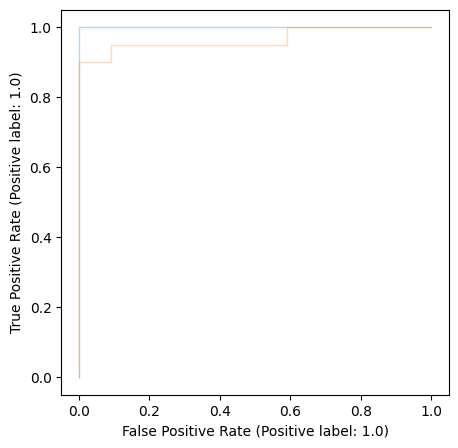

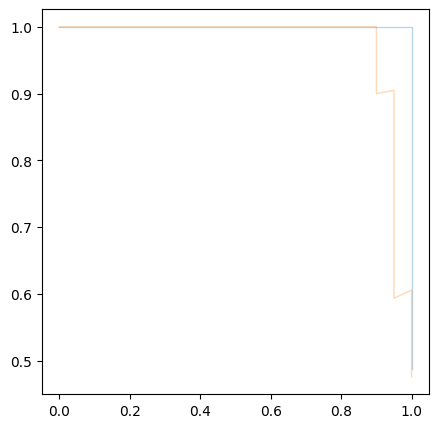

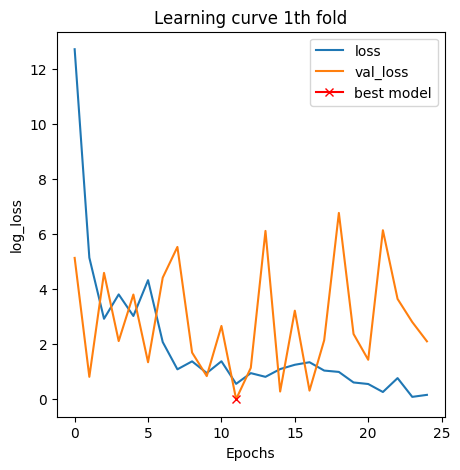

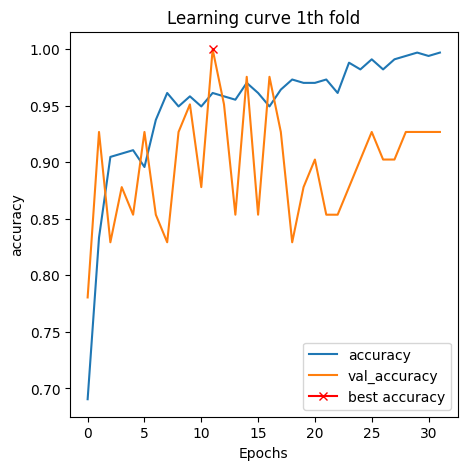

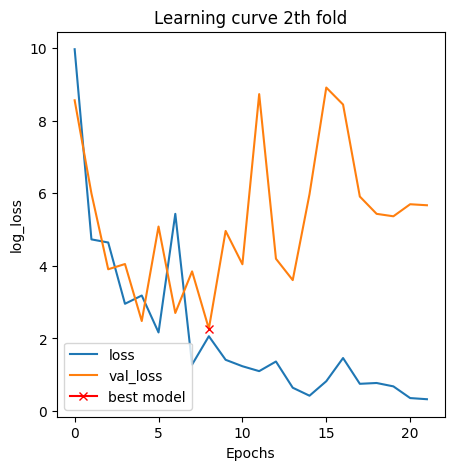

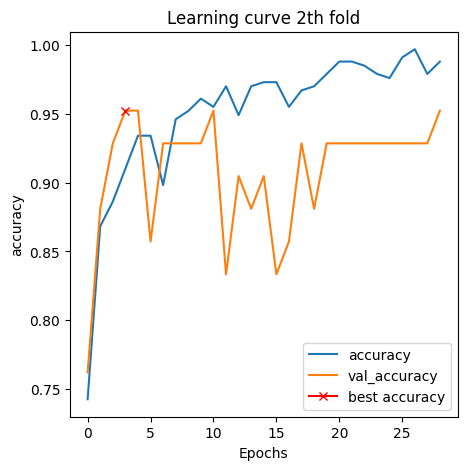

In [29]:
images_train = pickle.load(open("/content/" + "train_slo_iran.pkl", 'rb'))
labels_train = pickle.load(open("/content/" +"train_labels_Iran.pkl", 'rb'))

images_test = pickle.load(open("/content/" +"test_slo_iran.pkl", 'rb'))
labels_test = pickle.load(open("/content/" +"test_labels_Iran.pkl", 'rb'))
images_test,labels_test = preparing(images_test,labels_test)

images_test = np.repeat (images_test, repeats = 3, axis = 3)
#####################################################################
## Parameters
#####################################################################
channel = 3
number_class = 2

cnn_acc    = []
cnn_se     = []
cnn_sp     = []
cnn_pr     = []
cnn_f1     = []
cnn_auc    = []
cnn_pr_auc = []

test_acc    = []
test_se     = []
test_sp     = []
test_pr     = []
test_f1     = []
test_auc    = []
test_pr_auc = []


class_acc = np.zeros((number_class))
class_acc_test = np.zeros((number_class))

target_names = ['Normal' , 'MS']
confusion_matrix = np.zeros((number_class, number_class))
confusion_matrix_test = np.zeros((number_class, number_class))

y_test = []
tprs   = []
aucs   = []
y_pred = []
x_test = {}

mean_fpr  = np.linspace(0, 1, 100)
fig, ax   = plt.subplots(figsize=(5, 5))
fig1, ax1 = plt.subplots(figsize=(5, 5))





#### model parameters for res101
batch_size_slo  =    16                                #8
epoch         = 100
filter_num    = 32
learning_rate_slo =  0.0001581229399977375             #0.0016292158358323944


#####################################################################
## Applying kfold
#####################################################################

nfold = 5  #please enter number of folds

kf_nfold = StratifiedKFold(n_splits=nfold, random_state=None, shuffle=True)

n = 0
for train_index, val_index in kf_nfold.split(images_train,list(labels_train.values())):
    n = n+1
    # print(train_index, val_index)  # you can watch train and validation index using this comment
    print(f'---------------------------------------------------------------------\
          \n \t\t\t {n}th fold \n---------------------------------------------------------------------'\
          ,end = '\n\n\n' )
    train_index, val_index = next (skf.split (images_train, list(labels_train.values())))

    x_train = {i: images_train[list(images_train.keys())[i]]  for i in train_index}

    x_valid = {i: images_train[list(images_train.keys())[i]]  for i in val_index}

    y_train = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}

    y_valid = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}

    x_train,y_train = preparing(x_train,y_train)

    x_valid,y_valid = preparing(x_valid,y_valid)

    #x_test[n] = x_valid
    ################# Augmentation


    x_train,y_train = Augmentation_slo (x_train,y_train)

    indices = np.random.permutation (len (x_train))

    x_train = x_train [indices]
    y_train = y_train [indices]

    x_train = np.repeat (x_train, repeats = 3, axis = 3)

    x_valid = np.repeat (x_valid, repeats = 3, axis = 3)

    ####################################################################
    # classification
    ####################################################################

    input_img = Input((np.shape(x_train)[1], np.shape(x_train)[2], channel))

    model = cnn_feature_extractor(input_img)


    METRICS = [
#      keras.metrics.TruePositives(name='tp'),
#      keras.metrics.FalsePositives(name='fp'),
#      keras.metrics.TrueNegatives(name='tn'),
#      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
#      keras.metrics.Precision(name='precision'),
#      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
#      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      ]


    my_optimizer =  tf.keras.optimizers.Adam(lr=learning_rate_slo)
    model.compile(optimizer=my_optimizer, loss="binary_crossentropy", metrics=METRICS)
    callbacks = [EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
        ModelCheckpoint(f'oct{n}.h5', verbose=1, save_best_only=True, save_weights_only=True)]

    model.summary()

    #################################
    ###### Applying model  ###########
    #################################
    results = model.fit(x_train, y_train, batch_size=batch_size_slo, epochs=epoch, callbacks=callbacks,\
                    validation_data=(x_valid, np.asarray(y_valid, dtype=np.float64)))


    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["loss"][:-7], label="loss")
    plt.plot(results.history["val_loss"][:-7], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["accuracy"], label="accuracy")
    plt.plot(results.history["val_accuracy"], label="val_accuracy")
    plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]),\
             marker="x", color="r", label="best accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()


    # load the best model
    model.load_weights(f'oct{n}.h5')


    pred_proba = model.predict(x_valid).ravel()
    pred_class = (pred_proba > 0.5).astype(np.uint8)


    ##### calculating metrics

    cnn_acc.append(metrics.accuracy_score(y_valid, pred_class))
    print(f'accuracy of {n}th fold : {metrics.accuracy_score(y_valid, pred_class)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(y_valid, pred_class, pred_proba)

    cnn_sp.append(SP)
    cnn_se.append(SE)
    cnn_pr.append(PR)
    cnn_f1.append(f1)
    cnn_auc.append(ROC_AUC)
    cnn_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc  = np.add(class_acc,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix = np.add(confusion_matrix,cm)

######################## internal test
    pred_proba_test = model.predict(images_test).ravel()
    pred_class_test = (pred_proba_test > 0.5).astype(np.uint8)


    ##### calculating metrics
    print(f'test accuracy of {n}th fold : {metrics.accuracy_score(labels_test, pred_class_test)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(labels_test, pred_class_test, pred_proba_test)

    test_acc.append(metrics.accuracy_score(labels_test, pred_class_test))
    test_sp.append(SP)
    test_se.append(SE)
    test_pr.append(PR)
    test_f1.append(f1)
    test_auc.append(ROC_AUC)
    test_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc_test  = np.add(class_acc_test,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix_test = np.add(confusion_matrix_test,cm)

    ###################### Ploting ROC and PR curves for each fold ############
    y_test = np.append(y_test, y_valid, axis = 0)
    y_pred = np.append(y_pred, pred_proba, axis = 0)
    ###
    tprs, aucs = fold_curves(ax, ax1, y_valid, n, mean_fpr, pred_proba, tprs, aucs)

######################  the mean Ploting ROC and PR curves ############
###
curve_ploting(ax, ax1, mean_fpr, aucs, tprs, y_test, y_pred, 'CNN' )

plt.show()

#######################################
    # ploting confusion matrix
#######################################
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix/nfold, display_labels=target_names)
disp.plot()


########################################
#     Metrics printing
########################################
cnn_accc     = np.mean(cnn_acc)
cnn_spp      = np.mean(cnn_sp)
cnn_see      = np.mean(cnn_se)
cnn_prr      = np.mean(cnn_pr)
cnn_f11      = np.mean(cnn_f1)
cnn_aucc     = np.mean(cnn_auc)
cnn_pr_aucc  = np.mean(cnn_pr_auc)

###################### internal test
test_accc     = np.mean(test_acc)
test_spp      = np.mean(test_sp)
test_see      = np.mean(test_se)
test_prr      = np.mean(test_pr)
test_f11      = np.mean(test_f1)
test_aucc     = np.mean(test_auc)
test_pr_aucc  = np.mean(test_pr_auc)

#################### acc for each class ##################
class_acc  = class_acc/nfold
class_acc_test  = class_acc_test/nfold

print('cnn_acc     = %f' % cnn_accc)
print('cnn_sp      = %f' % cnn_spp)
print('cnn_se      = %f' % cnn_see)
print('cnn_pr      = %f' % cnn_prr)
print('cnn_f1      = %f' % cnn_f11)
print('cnn_auc     = %f' % cnn_aucc)
print('cnn_pr_auc  = %f' % cnn_pr_aucc, end='\n\n')


print('acc of class %s' % target_names[0], '= %f' % class_acc[0])
print('acc of class %s' % target_names[1], '= %f' % class_acc[1], end='\n\n')

print('test_acc     = %f' % test_accc)
print('test_sp      = %f' % test_spp)
print('test_se      = %f' % test_see)
print('test_pr      = %f' % test_prr)
print('test_f1      = %f' % test_f11)
print('test_auc     = %f' % test_aucc)
print('test_pr_auc  = %f' % test_pr_aucc, end='\n\n')


print('test acc of class %s' % target_names[0], '= %f' % class_acc_test[0])
print('test acc of class %s' % target_names[1], '= %f' % class_acc_test[1], end='\n\n')